<a href="https://colab.research.google.com/github/bandido007/Conformal-Prediction-projects/blob/main/Regularized_Adaptive_Conformal_Prediction_for_Heart_Disease_Risk_Assessment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
!pip -q install catboost
from catboost import CatBoostClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

!pip -q install tabulate
from tabulate import tabulate

import traceback


# ***Conformal Prediction***
here is the implementation of the Regularized Adaptive Prediction Set
-

In [170]:
class EnhancedRAPSCardiac:
    """
    Enhanced Regularized Adaptive Prediction Sets (RAPS) implementation for heart disease diagnostics.
    Implements conformal prediction with additional cardiac-specific enhancements.
    """
    def __init__(self, base_model, confidence_threshold=0.9, uncertainty_threshold=0.65):
        """
        Initialize the RAPS model with cardiac-specific thresholds.

        Args:
            base_model: Any sklearn-compatible classifier with predict_proba method
            confidence_threshold (float): Threshold for high-confidence predictions
            uncertainty_threshold (float): Threshold for uncertain predictions
        """
        self.base_model = base_model
        self.confidence_threshold = confidence_threshold
        self.uncertainty_threshold = uncertainty_threshold
        self.conformal_metrics = ConformalMetrics()
        self.calibration_scores = None
        self.calibration_threshold = None

    def predict_with_confidence(self, X):
        """
        Make predictions with confidence assessment.
        Provides both predictions and uncertainty quantification.

        Args:
            X (np.array): Input features

        Returns:
            tuple: (prediction_set, confidence_score, assessment_label)
        """
        if not hasattr(self.base_model, 'predict_proba'):
            raise AttributeError("Base model must support predict_proba")

        # Get probability predictions
        probs = self.base_model.predict_proba(X.reshape(1, -1))
        sorted_probs = np.sort(probs[0])[::-1]
        max_prob = sorted_probs[0]
        ordered_classes = np.argsort(probs[0])[::-1]

        # Map numeric classes to interpretable labels
        class_labels = {0: "No Heart Disease", 1: "Heart Disease Present"}

        # Map numeric classes to interpretable labels
        if max_prob >= self.confidence_threshold:
            prediction_set = [class_labels[ordered_classes[0]]]
            assessment = "Definitive"
        elif max_prob < self.uncertainty_threshold:
            prediction_set = [class_labels[c] for c in ordered_classes[:2]]
            assessment = "Highly Uncertain"
        else:
            prediction_set = [class_labels[ordered_classes[0]]]
            if sorted_probs[1] > self.uncertainty_threshold / 2:
                prediction_set.append(class_labels[ordered_classes[1]])
            assessment = "Uncertain"

        return prediction_set, max_prob, assessment

    def calibrate(self, X_cal, y_cal, alpha=0.1):
        """Calibrate the model using conformal prediction."""
        scores = self.compute_nonconformity_scores(X_cal, y_cal)
        self.calibration_scores = scores
        self.calibration_threshold = np.quantile(scores, 1 - alpha)

    def compute_nonconformity_scores(self, X, y_true):
        """Compute nonconformity scores."""
        probs = self.base_model.predict_proba(X)
        scores = 1 - probs[np.arange(len(y_true)), y_true]
        return scores

    def regularized_conformal_prediction(self, X_train, y_train, X_cal, y_cal,
                                       X_test, y_test, alpha=0.1, reg_param=0.1,
                                       n_trials=100, randomized=True):
        """
        Implement regularized adaptive conformal prediction with multiple trials.

        Args:
            X_train, y_train: Training data
            X_cal, y_cal: Calibration data
            X_test, y_test: Test data
            alpha (float): Target miscoverage rate (default: 0.1)
            reg_param (float): Regularization parameter (default: 0.01)
            n_trials (int): Number of random trials (default: 100)
            randomized (bool): Whether to use randomization (default: True)

        Returns:
            dict: Comprehensive results including coverages, set sizes, and metrics
        """
        results = {
            'coverages': [],
            'set_sizes': [],
            'thresholds': [],
            'prediction_sets': [],
            'metrics': {}
        }

        for _ in range(n_trials):
            # Train base model
            self.base_model.fit(X_train, y_train)

            # Get probability predictions
            cal_probs = self.base_model.predict_proba(X_cal)
            test_probs = self.base_model.predict_proba(X_test)

            # Apply regularization
            n_classes = cal_probs.shape[1]
            reg_vec = reg_param * np.exp(-np.arange(n_classes))

            # Sort probabilities and apply regularization
            cal_pi = cal_probs.argsort(1)[:,::-1]
            cal_srt = np.take_along_axis(cal_probs, cal_pi, axis=1)
            cal_srt_reg = cal_srt + reg_vec

            # Calculate conformity scores
            n_cal = len(y_cal)
            cal_L = np.where(cal_pi == y_cal.values[:, None])[1]

            # Add randomization if enabled
            if randomized:
                rand_terms = np.random.rand(n_cal) * cal_srt_reg[np.arange(n_cal), cal_L]
            else:
                rand_terms = 0

            # Calculate calibration scores and threshold
            cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n_cal), cal_L] - rand_terms
            threshold = np.quantile(cal_scores,
                                  np.ceil((n_cal+1)*(1-alpha))/n_cal,
                                  method='higher')

            # Generate prediction sets for test data
            n_test = len(y_test)
            test_pi = test_probs.argsort(1)[:,::-1]
            test_srt = np.take_along_axis(test_probs, test_pi, axis=1)
            test_srt_reg = test_srt + reg_vec
            test_cumsum = test_srt_reg.cumsum(axis=1)

            # Apply randomization to test predictions
            if randomized:
                indicators = (test_cumsum - np.random.rand(n_test, 1) * test_srt_reg) <= threshold
            else:
                indicators = test_cumsum - test_srt_reg <= threshold

            # Ensure at least one prediction per set
            indicators[:, 0] = True
            pred_sets = np.take_along_axis(indicators, test_pi.argsort(axis=1), axis=1)

            # Calculate and store metrics
            results['coverages'].append(self.conformal_metrics.average_coverage(pred_sets, y_test))
            results['set_sizes'].append(self.conformal_metrics.average_set_size(pred_sets))
            results['thresholds'].append(threshold)
            results['prediction_sets'].append(pred_sets)

        # Calculate final prediction sets and metrics
        final_pred_sets = np.stack(results['prediction_sets']).mean(axis=0) > 0.5

        # Store comprehensive metrics
        results['metrics'] = {
            'average_coverage': np.mean(results['coverages']),
            'average_set_size': np.mean(results['set_sizes']),
            'error_rate': self.conformal_metrics.error_rate(final_pred_sets, y_test),
            'efficiency': self.conformal_metrics.efficiency(final_pred_sets)
        }

        # Add age-stratified coverage if available
        if isinstance(X_test, pd.DataFrame) and 'age' in X_test.columns:
            age_groups = pd.qcut(X_test['age'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
            results['metrics']['age_stratified_coverage'] = \
                self.conformal_metrics.stratified_coverage(final_pred_sets, y_test, age_groups)

        return results

In [171]:
class ConformalMetrics:
    """
    A class for calculating various metrics for conformal prediction evaluation.
    This class provides methods to assess the quality and reliability of conformal prediction sets.
    """

    def average_coverage(self, pred_sets, y_true):
        """
        Calculate the average coverage of the prediction sets.

        Args:
            pred_sets: numpy array of prediction sets (binary indicators)
            y_true: true labels (numpy array or pandas series)
        """

        if isinstance(y_true, pd.Series):
            y_true = y_true.values

        # Convert prediction sets to binary indicators if not already
        if isinstance(pred_sets, list):
            pred_sets = np.array(pred_sets)

        # Calculate coverage for binary classification
        correct = pred_sets[np.arange(len(y_true)), y_true]
        return np.mean(correct)

    def average_set_size(self, pred_sets):
        """
        Calculate the average size of prediction sets.
        Smaller set sizes indicate more precise predictions.

        Args:
            pred_sets (np.array/list): Prediction sets

        Returns:
            float: Average number of predictions per set
        """
        if isinstance(pred_sets, list):
            pred_sets = np.array(pred_sets)
        return np.mean(np.sum(pred_sets, axis=1))

    def error_rate(self, pred_sets, y_true):
        """
        Calculate the error rate (complement of coverage).

        Args:
            pred_sets (np.array): Prediction sets
            y_true (np.array): True labels

        Returns:
            float: Proportion of incorrect predictions
        """
        return 1 - self.average_coverage(pred_sets, y_true)

    def efficiency(self, pred_sets):
        """Calculate efficiency (mean set size)."""
        return self.average_set_size(pred_sets)

    def stratified_coverage(self, pred_sets, y_true, stratification):
        """
        Calculate coverage separately for different groups/strata.
        Useful for assessing fairness and bias across different subgroups.

        Args:
            pred_sets (np.array): Prediction sets
            y_true (np.array): True labels
            stratification (np.array): Group labels for stratification

        Returns:
            dict: Coverage for each stratum
        """

        if isinstance(y_true, pd.Series):
            y_true = y_true.values
        if isinstance(stratification, pd.Series):
            stratification = stratification.values

        results = {}
        for group in np.unique(stratification):
            mask = stratification == group
            coverage = self.average_coverage(pred_sets[mask], y_true[mask])
            results[group] = coverage
        return results

    def conditional_coverage(self, pred_sets, y_true, conditions):
        """Calculate conditional coverage for specific conditions."""
        if isinstance(y_true, pd.Series):
            y_true = y_true.values
        if isinstance(conditions, pd.Series):
            conditions = conditions.values

        results = {}
        for condition in np.unique(conditions):
            mask = conditions == condition
            coverage = self.average_coverage(pred_sets[mask], y_true[mask])
            results[condition] = coverage
        return results

In [182]:
class EnhancedHeartDiseaseAnalyzer:
    def __init__(self, data_path):
        """
        Initialize the Heart Attack Analyzer for the Kaggle dataset.

        The dataset contains the following features:
        - age: Age of the patient
        - sex: Sex of the patient (1 = male, 0 = female)
        - cp: Chest pain type (0-3)
        - trtbps: Resting blood pressure (in mm Hg)
        - chol: Cholesterol in mg/dl
        - fbs: Fasting blood sugar > 120 mg/dl (1 = true)
        - restecg: Resting electrocardiographic results (0-2)
        - thalachh: Maximum heart rate achieved
        - exng: Exercise induced angina (1 = yes)
        - oldpeak: ST depression induced by exercise relative to rest
        - slp: Slope of the peak exercise ST segment
        - caa: Number of major vessels (0-3)
        - thall: Thalassemia types
        - output: Target variable (1 = heart disease, 0 = normal)
        """
        self.data_path = data_path
        self.scaler = StandardScaler()
        self.models = {}
        self.stacking_model = None
        self.feature_names = None

    def _get_assessment(self, confidence):
        """
        Determine assessment level based on confidence score.

        Args:
            confidence (float): Confidence score between 0 and 1

        Returns:
            str: Assessment level description
        """
        if confidence >= 0.90:
            return "Definitive prediction with high confidence"
        elif confidence >= 0.70:
            return "Uncertain prediction with moderate confidence"
        else:
            return "Highly uncertain prediction with low confidence"

    def plot_comprehensive_analysis(self, all_results, y_test):
        """Enhanced visualization with integrated metrics plotting."""
        fig = plt.figure(figsize=(20, 20))
        gs = fig.add_gridspec(4, 2)

        ax1 = fig.add_subplot(gs[0, 0])
        for model_name, results in all_results.items():
            sns.kdeplot(results['coverages'], label=model_name, ax=ax1)
        ax1.axvline(0.9, color='red', linestyle='--', label='Target (1-α)')
        ax1.set_title('Coverage Distribution Across Trials')
        ax1.set_xlabel('Coverage')
        ax1.legend()

        ax2 = fig.add_subplot(gs[0, 1])
        for model_name, results in all_results.items():
            sns.kdeplot(results['set_sizes'], label=model_name, ax=ax2)
        ax2.set_title('Set Size Distribution')
        ax2.set_xlabel('Average Set Size')
        ax2.legend()

        ax3 = fig.add_subplot(gs[1, 0])
        for model_name, results in all_results.items():
            ax3.scatter(results['set_sizes'], results['coverages'],
                       alpha=0.5, label=model_name)
        ax3.set_xlabel('Average Set Size')
        ax3.set_ylabel('Coverage')
        ax3.set_title('Coverage vs Set Size Trade-off')
        ax3.legend()

        ax4 = fig.add_subplot(gs[1, 1])
        class_coverage_data = []
        for model_name, results in all_results.items():
            metrics = results['metrics']
            for i, cov in enumerate([metrics['average_coverage']]):
                class_coverage_data.append({
                    'Model': model_name,
                    'Class': f'Class {i}',
                    'Coverage': cov
                })
        df_class_cov = pd.DataFrame(class_coverage_data)
        sns.boxplot(data=df_class_cov, x='Class', y='Coverage', hue='Model', ax=ax4)
        ax4.set_title('Class-conditional Coverage')

        ax5 = fig.add_subplot(gs[2, 0])
        for model_name, results in all_results.items():
            ax5.plot(results['coverages'], label=model_name)
        ax5.set_title('Coverage over Trials')
        ax5.set_xlabel('Trial')
        ax5.set_ylabel('Coverage')
        ax5.grid(True)
        ax5.legend()

        ax6 = fig.add_subplot(gs[2, 1])
        for model_name, results in all_results.items():
            ax6.plot(results['set_sizes'], label=model_name)
        ax6.set_title('Set Size over Trials')
        ax6.set_xlabel('Trial')
        ax6.set_ylabel('Average Set Size')
        ax6.grid(True)
        ax6.legend()

        ax7 = fig.add_subplot(gs[3, 0])
        for model_name, results in all_results.items():
            ax7.plot(results['thresholds'], label=model_name)
        ax7.set_title('Threshold over Trials')
        ax7.set_xlabel('Trial')
        ax7.set_ylabel('Threshold')
        ax7.grid(True)
        ax7.legend()

        ax8 = fig.add_subplot(gs[3, 1])
        error_data = []
        for model_name, results in all_results.items():
            metrics = results['metrics']
            error_data.append({
                'Model': model_name,
                'Error Rate': metrics['error_rate'],
                'Efficiency': metrics['efficiency']
            })
        df_errors = pd.DataFrame(error_data)
        df_errors.plot(x='Error Rate', y='Efficiency', kind='scatter', ax=ax8)
        for i, row in df_errors.iterrows():
            ax8.annotate(row['Model'], (row['Error Rate'], row['Efficiency']))
        ax8.set_title('Error Rate vs Efficiency')

        plt.tight_layout()
        return fig

    def load_and_prepare_data(self):
        """
        Load and preprocess the Kaggle heart attack dataset.
        """
        try:
            # Load data
            df = pd.read_csv(self.data_path)

            # Verify expected columns
            expected_columns = {
                'age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg',
                'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'
            }

            # Print actual columns for debugging
            print("Available columns:", df.columns.tolist())

            # Check if all expected columns are present
            missing_cols = expected_columns - set(df.columns)
            if missing_cols:
                print(f"Warning: Missing expected columns: {missing_cols}")

            # Split features and target
            X = df.drop('output', axis=1)
            self.feature_names = X.columns.tolist()
            y = df['output']

            # Split into train, calibration, and test sets
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=0.3, random_state=42
            )
            X_cal, X_test, y_cal, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42
            )

            # Scale the features
            X_train_scaled = pd.DataFrame(
                self.scaler.fit_transform(X_train),
                columns=self.feature_names,
                index=X_train.index
            )
            X_cal_scaled = pd.DataFrame(
                self.scaler.transform(X_cal),
                columns=self.feature_names,
                index=X_cal.index
            )
            X_test_scaled = pd.DataFrame(
                self.scaler.transform(X_test),
                columns=self.feature_names,
                index=X_test.index
            )

            # Print data summary
            self._print_data_summary(df, X_train_scaled, X_cal_scaled, X_test_scaled)

            return (df, X_train_scaled, X_cal_scaled, X_test_scaled,
                    y_train, y_cal, y_test)

        except Exception as e:
            print(f"Error in data loading and preparation: {str(e)}")
            traceback.print_exc()
            return None, None, None, None, None, None, None

    def train_multiple_models(self, X_train_scaled, y_train, X_cal_scaled, y_cal):
        """Train and calibrate multiple models for heart disease prediction."""
        base_models = {
            'logistic': (LogisticRegression(random_state=42),
                        {'C': [0.1, 1, 10]}),
            'random_forest': (RandomForestClassifier(random_state=42),
                            {'n_estimators': [100, 200], 'max_depth': [5, 10]}),
            'svm': (SVC(probability=True, random_state=42),
                   {'C': [1], 'kernel': ['rbf']}),
            'xgboost': (XGBClassifier(random_state=42),
                       {'learning_rate': [0.1], 'max_depth': [3, 5]}),
            'gradient_boosting': (GradientBoostingClassifier(random_state=42),
                                {'n_estimators': [100], 'learning_rate': [0.1]})
        }

        try:
            for name, (model, param_grid) in base_models.items():
                print(f"Training {name}...")
                grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
                grid_search.fit(X_train_scaled, y_train)

                enhanced_model = EnhancedRAPSCardiac(grid_search.best_estimator_)
                enhanced_model.calibrate(X_cal_scaled, y_cal)
                self.models[name] = enhanced_model

            estimators = [(name, model.base_model) for name, model in self.models.items()]
            self.stacking_model = StackingClassifier(
              estimators=estimators,
              final_estimator=RandomForestClassifier(),
              n_jobs=-1
            )
            self.stacking_model.fit(X_train_scaled, y_train)

            print("Model training completed successfully.")

        except Exception as e:
            print(f"Error in model training: {str(e)}")
            traceback.print_exc()


    def process_patients_multi_model(self, df, num_samples=10):
        """Process heart disease samples with enhanced interpretation for multiple models."""
        try:
            # Determine the target column based on available columns
            if 'target' in df.columns:
                target_column = 'target'
            elif 'diagnosis' in df.columns:
                target_column = 'diagnosis'
            elif 'output' in df.columns:
                target_column = 'output'
            else:
                print("Error: Neither 'target', 'diagnosis', nor 'output' column is found in the DataFrame.")
                return

            # Sample the patients
            sample_patients = df.sample(n=min(num_samples, len(df)), random_state=42)

            print("\nSample Analysis Results:")
            print("=" * 100)

            # Process each sampled patient
            for idx, patient in sample_patients.iterrows():
                features = patient.drop(target_column)

                # Ensure consistent feature names for scaler transformation
                features = features.rename(index={'trtbps': 'trestbps', 'thalachh': 'thalach'})  # Update column names if needed
                scaled_features = self.scaler.transform([features.values])[0]

                print(f"\nPatient ID: {idx}")
                print("-" * 50)

                # Display Basic Information with corrected column names
                print("Key Measurements:")
                print(f"• Age: {patient['age']}")
                print(f"• Gender: {'Male' if patient['sex'] == 1 else 'Female'}")
                print(f"• Resting Blood Pressure: {patient['trtbps']} mm Hg")  # Adjusted column name
                print(f"• Cholesterol: {patient['chol']} mg/dl")
                print(f"• Max Heart Rate: {patient['thalachh']} bpm")  # Adjusted column name

                # Risk Factors
                risk_factors = self._assess_risk_factors(patient)
                print("\nRisk Indicators:")
                for factor in risk_factors:
                    print(f"• {factor}")

                # Actual Diagnosis
                diagnosis = 'Present' if patient[target_column] == 1 else 'Absent'
                print(f"\nActual Heart Disease Status: {diagnosis}")

                # Model Predictions
                print("\nModel Predictions:")
                print("-" * 30)

                # Individual model predictions
                for model_name, model in self.models.items():
                    try:
                        pred_set, conf, assessment = model.predict_with_confidence(scaled_features)
                        print(f"\n{model_name.title()} Model:")
                        print(f"• Prediction: {', '.join(pred_set)}")
                        print(f"• Confidence: {conf:.1%}")
                        print(f"• Assessment: {assessment}")
                    except Exception as e:
                        print(f"• Error in {model_name} prediction: {str(e)}")
                        continue

                # Ensemble prediction
                print("\nEnsemble Model:")
                stack_probs = self.stacking_model.predict_proba([scaled_features])[0]
                stack_pred = "Present" if stack_probs[1] > 0.5 else "Not Present"
                stack_conf = max(stack_probs)
                stack_assessment = self._get_assessment(stack_conf)

                print(f"• Prediction: {stack_pred}")
                print(f"• Confidence: {stack_conf:.1%}")
                print(f"• Assessment: {stack_assessment}")

                print("\n" + "=" * 100)  # End of patient separator

            self._print_interpretation_guide()

        except Exception as e:
            print(f"Error in sample processing: {str(e)}")






    def process_patients(self, df, num_samples=10):
        """Process heart disease samples with enhanced interpretation."""
        try:
            # Identify the target column
            target_column = 'target' if 'target' in df.columns else 'diagnosis'

            if target_column not in df.columns:
                print(f"Error: Target column '{target_column}' is missing from DataFrame.")
                return

            sample_patients = df.sample(n=min(num_samples, len(df)), random_state=42)

            print("\nSample Analysis Results:")
            print("=" * 100)

            for idx, patient in sample_patients.iterrows():
                features = patient.drop(target_column)
                scaled_features = self.scaler.transform([features.values])[0]

                print(f"\nPatient ID: {idx}")
                print("-" * 50)

                # Calculate predictions from all models
                predictions = {}
                for name, model in self.models.items():
                    try:
                        proba = model.predict_proba([scaled_features])[0]
                        pred = "Present" if proba[1] > 0.5 else "Absent"
                        conf = max(proba)
                        assessment = self._get_assessment(conf)
                        predictions[name] = (pred, conf, assessment)
                    except Exception as e:
                        print(f"Error in {name} prediction: {str(e)}")
                        continue

                # Print predictions
                print("\nModel Predictions:")
                for name, (pred, conf, assessment) in predictions.items():
                    print(f"\n{name.title()} Model:")
                    print(f"• Prediction: {pred}")
                    print(f"• Confidence: {conf:.1%}")
                    print(f"• Assessment: {assessment}")

                # Ensemble prediction
                if self.stacking_model:
                    stack_probs = self.stacking_model.predict_proba([scaled_features])[0]
                    stack_pred = "Present" if stack_probs[1] > 0.5 else "Absent"
                    stack_conf = max(stack_probs)
                    stack_assessment = self._get_assessment(stack_conf)

                    print("\nEnsemble Model:")
                    print(f"• Prediction: {stack_pred}")
                    print(f"• Confidence: {stack_conf:.1%}")
                    print(f"• Assessment: {stack_assessment}")

                # Actual diagnosis
                actual = "Present" if patient[target_column] == 1 else "Absent"
                print(f"\nActual Heart Disease Status: {actual}")

                print("\n" + "=" * 100)

        except Exception as e:
            print(f"Error in sample processing: {str(e)}")
            traceback.print_exc()


    def _print_interpretation_guide(self):
        """Print the interpretation guide for heart disease prediction."""
        print("\nInterpretation Guide")
        print("=" * 50)

        print("\nAssessment Levels:")
        print("• Definitive: Very high confidence (≥90%)")
        print("• Uncertain: Moderate confidence (70-89%)")
        print("• Highly Uncertain: Low confidence (<70%)")

        print("\nKey Measurements:")
        print("• Age: Patient's age in years")
        print("• Sex: Gender (1 = male, 0 = female)")
        print("• CP: Chest pain type (0-3)")
        print("• Trestbps: Resting blood pressure (mm Hg)")
        print("• Chol: Serum cholesterol (mg/dl)")
        print("• Fbs: Fasting blood sugar > 120 mg/dl (1 = true)")
        print("• Restecg: Resting ECG results (0-2)")
        print("• Thalach: Maximum heart rate achieved")
        print("• Exang: Exercise induced angina (1 = yes)")
        print("• Oldpeak: ST depression induced by exercise")
        print("• Slope: Slope of peak exercise ST segment")
        print("• Ca: Number of major vessels colored by flourosopy")
        print("• Thal: Thalassemia type")

        print("\nConfidence Interpretation:")
        print("• Higher confidence indicates more reliable predictions")
        print("• Multiple predictions suggest model uncertainty")
        print("• Ensemble predictions combine insights from all models")


    def _print_data_summary(self, df, X_train, X_cal, X_test):
        """Print comprehensive data summary with specific focus on heart attack indicators."""
        print("\nHeart Attack Analysis Dataset Summary:")
        print("=" * 60)

        # Dataset splits information
        print("\nDataset Splits:")
        print(f"Total dataset: {df.shape[0]} patients, {df.shape[1]} features")
        print(f"Training set: {X_train.shape[0]} patients")
        print(f"Calibration set: {X_cal.shape[0]} patients")
        print(f"Test set: {X_test.shape[0]} patients")

        # Target distribution
        print("\nDisease Distribution:")
        target_dist = df['output'].value_counts(normalize=True) * 100
        print(f"Positive cases (Heart Disease): {target_dist[1]:.1f}%")
        print(f"Negative cases (Normal): {target_dist[0]:.1f}%")

        # Feature statistics
        print("\nFeature Statistics:")
        print("-" * 60)
        stats = df.describe()
        print(stats)

        # Check for any remaining missing values
        missing = df.isnull().sum()
        if missing.any():
            print("\nWarning: Missing values detected:")
            print(missing[missing > 0])

        # Print correlation with target
        print("\nFeature Correlations with Heart Disease:")
        correlations = df.corr()['output'].sort_values(ascending=False)
        print(correlations)


    def _assess_risk_factors(self, sample):
        """
        Assess and return risk factors for a heart disease sample based on measurements.
        """
        risk_factors = []

        # Age risk
        if sample['age'] > 60:
            risk_factors.append(f"Advanced age ({sample['age']} years)")

        # Gender risk (being male is a risk factor)
        if sample['sex'] == 1:
            risk_factors.append("Male gender (higher risk category)")

        # Blood pressure risk
        if sample['trtbps'] >= 140:  # Adjusted to match 'trtbps'
            risk_factors.append(f"High blood pressure ({sample['trtbps']} mm Hg)")

        # Cholesterol risk
        if sample['chol'] > 200:
            risk_factors.append(f"High cholesterol ({sample['chol']} mg/dl)")

        # Heart rate risk
        if sample['thalachh'] > 170:  # Adjusted to match 'thalachh'
            risk_factors.append(f"Elevated maximum heart rate ({sample['thalachh']} bpm)")
        elif sample['thalachh'] < 100:
            risk_factors.append(f"Low maximum heart rate ({sample['thalachh']} bpm)")

        # Fasting blood sugar risk
        if sample['fbs'] > 0:
            risk_factors.append("High fasting blood sugar (>120 mg/dl)")

        # Exercise-induced angina
        if sample['exng'] > 0:
            risk_factors.append("Presence of exercise-induced angina")

        # ST depression risk (oldpeak)
        if sample['oldpeak'] >= 2:
            risk_factors.append(f"Significant ST depression ({sample['oldpeak']})")

        # Number of vessels affected (caa)
        if sample['caa'] > 0:  # Adjusted to match 'caa'
            risk_factors.append(f"Major vessels affected: {int(sample['caa'])}")

        # Chest pain type
        cp_types = {
            1: "Typical angina",
            2: "Atypical angina",
            3: "Non-anginal pain",
            4: "Asymptomatic"
        }
        if sample['cp'] in cp_types:
            risk_factors.append(f"Chest pain type: {cp_types[sample['cp']]}")

        # Resting ECG abnormalities
        ecg_types = {
            0: "Normal",
            1: "ST-T wave abnormality",
            2: "Left ventricular hypertrophy"
        }
        if sample['restecg'] > 0:
            risk_factors.append(f"ECG abnormality: {ecg_types[sample['restecg']]}")

        # Thalassemia (thall)
        thal_types = {
            1: "Normal",
            2: "Fixed defect",
            3: "Reversible defect"
        }
        if sample['thall'] > 1:  # Adjusted to match 'thall'
            risk_factors.append(f"Thalassemia type: {thal_types[sample['thall']]}")

        # ST segment slope
        slope_types = {
            1: "Upsloping",
            2: "Flat",
            3: "Downsloping"
        }
        if sample['slp'] > 1:
            risk_factors.append(f"ST segment slope: {slope_types[sample['slp']]}")

        # Combined risk assessment
        high_risk_count = len(risk_factors)
        if high_risk_count >= 3:
            risk_factors.insert(0, f"Multiple risk factors present ({high_risk_count} factors)")

        # Return identified risk factors or default message
        return risk_factors if risk_factors else ["No significant risk factors identified"]



In [183]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle.json
!chmod 600 ~/.kaggle/.kaggle.json
!kaggle datasets download -d rashikrahmanpritom/heart-attack-analysis-prediction-dataset
!unzip heart-attack-analysis-prediction-dataset.zip

cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/.kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset
License(s): CC0-1.0
heart-attack-analysis-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  heart-attack-analysis-prediction-dataset.zip
replace heart.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: heart.csv               
replace o2Saturation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: o2Saturation.csv        


In [184]:
# Initialize your analyzer class
data_path = 'heart.csv'
analyzer = EnhancedHeartDiseaseAnalyzer(data_path)

In [185]:
# Cell 2: Load and Prepare Data
def load_prepare_data():
    print("Loading and preparing data...")
    result = analyzer.load_and_prepare_data()

    if result[0] is None:
        print("Error loading data!")
        return None

    return result

df, X_train_scaled, X_cal_scaled, X_test_scaled, y_train, y_cal, y_test = load_prepare_data()

Loading and preparing data...
Available columns: ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']

Heart Attack Analysis Dataset Summary:

Dataset Splits:
Total dataset: 303 patients, 14 features
Training set: 212 patients
Calibration set: 45 patients
Test set: 46 patients

Disease Distribution:
Positive cases (Heart Disease): 54.5%
Negative cases (Normal): 45.5%

Feature Statistics:
------------------------------------------------------------
              age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.0000

In [186]:
# Cell 3: Train and Calibrate Models
def train_models():
    print("\nTraining and calibrating models...")
    analyzer.train_multiple_models(X_train_scaled, y_train, X_cal_scaled, y_cal)

train_models()



Training and calibrating models...
Training logistic...
Training random_forest...
Training svm...
Training xgboost...
Training gradient_boosting...
Model training completed successfully.


In [187]:
# Cell 4: Run Conformal Prediction Analysis
def run_conformal_analysis():
    all_results = {}
    print("\nRunning conformal prediction analysis...")

    for model_name, model in analyzer.models.items():
        print(f"\nAnalyzing {model_name} with conformal prediction...")
        results = model.regularized_conformal_prediction(
            X_train_scaled, y_train,
            X_cal_scaled, y_cal,
            X_test_scaled, y_test
        )
        all_results[model_name] = results

        print(f"\n{model_name} Conformal Prediction Metrics:")
        print(f"Average Coverage: {results['metrics']['average_coverage']:.3f}")
        print(f"Average Set Size: {results['metrics']['average_set_size']:.3f}")
        print(f"Error Rate: {results['metrics']['error_rate']:.3f}")
        print(f"Efficiency: {results['metrics']['efficiency']:.3f}")

    return all_results

all_results = run_conformal_analysis()



Running conformal prediction analysis...

Analyzing logistic with conformal prediction...

logistic Conformal Prediction Metrics:
Average Coverage: 0.844
Average Set Size: 1.264
Error Rate: 0.152
Efficiency: 1.217

Analyzing random_forest with conformal prediction...

random_forest Conformal Prediction Metrics:
Average Coverage: 0.895
Average Set Size: 1.392
Error Rate: 0.065
Efficiency: 1.391

Analyzing svm with conformal prediction...

svm Conformal Prediction Metrics:
Average Coverage: 0.849
Average Set Size: 1.284
Error Rate: 0.152
Efficiency: 1.283

Analyzing xgboost with conformal prediction...

xgboost Conformal Prediction Metrics:
Average Coverage: 0.841
Average Set Size: 1.248
Error Rate: 0.152
Efficiency: 1.239

Analyzing gradient_boosting with conformal prediction...

gradient_boosting Conformal Prediction Metrics:
Average Coverage: 0.828
Average Set Size: 1.288
Error Rate: 0.174
Efficiency: 1.261


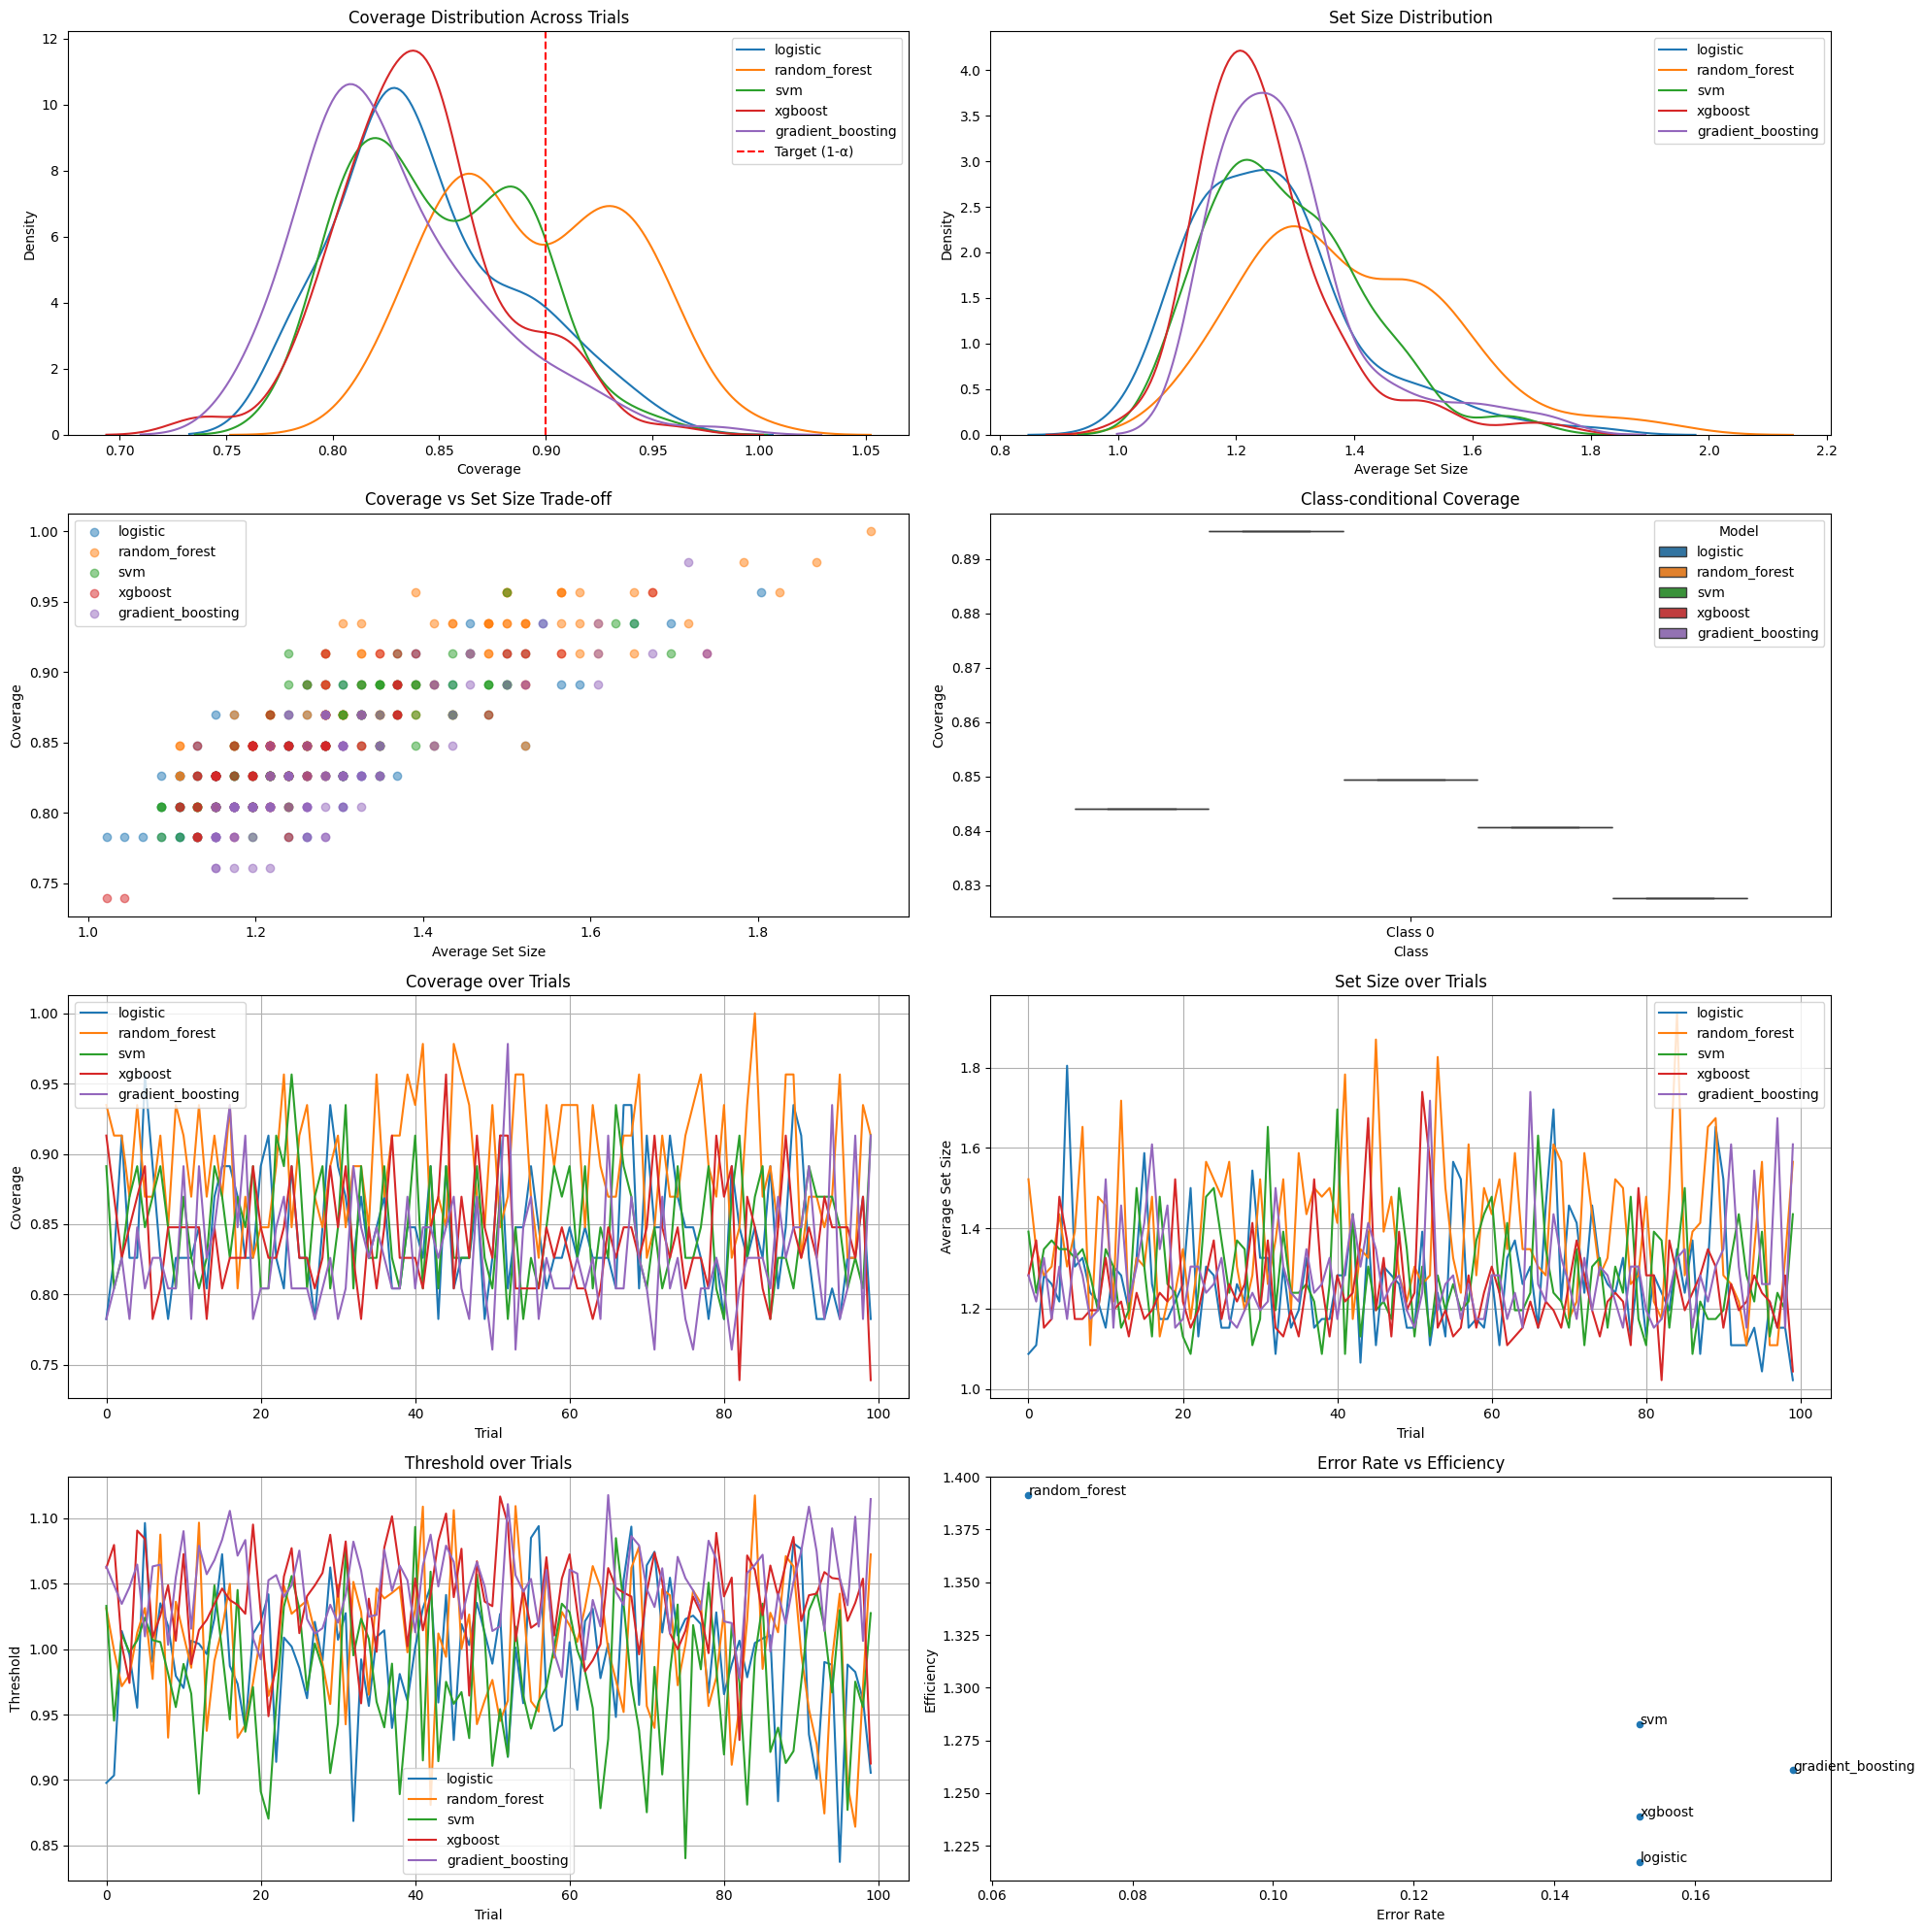

In [188]:
# Cell 5: Generate Visualization
def create_visualization():
    try:
        fig = analyzer.plot_comprehensive_analysis(all_results, y_test)
        plt.show()
    except Exception as e:
        print(f"Error creating visualization: {str(e)}")

create_visualization()

In [190]:
# Cell 6: Process Sample Patients
def analyze_sample_patients():
    print("\nAnalyzing sample patients...")
    try:
        analyzer.process_patients_multi_model(df, num_samples=5)
    except Exception as e:
        print(f"Error processing sample patients: {str(e)}")

analyze_sample_patients()


Analyzing sample patients...

Sample Analysis Results:

Patient ID: 179
--------------------------------------------------
Key Measurements:
• Age: 57.0
• Gender: Male
• Resting Blood Pressure: 150.0 mm Hg
• Cholesterol: 276.0 mg/dl
• Max Heart Rate: 112.0 bpm

Risk Indicators:
• Multiple risk factors present (5 factors)
• Male gender (higher risk category)
• High blood pressure (150.0 mm Hg)
• High cholesterol (276.0 mg/dl)
• Presence of exercise-induced angina
• Major vessels affected: 1

Actual Heart Disease Status: Absent

Model Predictions:
------------------------------

Logistic Model:
• Prediction: No Heart Disease
• Confidence: 81.0%
• Assessment: Uncertain

Random_Forest Model:
• Prediction: No Heart Disease
• Confidence: 89.5%
• Assessment: Uncertain

Svm Model:
• Prediction: No Heart Disease
• Confidence: 76.9%
• Assessment: Uncertain

Xgboost Model:
• Prediction: No Heart Disease
• Confidence: 99.5%
• Assessment: Definitive

Gradient_Boosting Model:
• Prediction: No Heart

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid featur


• Assessment: Highly uncertain prediction with low confidence


Patient ID: 246
--------------------------------------------------
Key Measurements:
• Age: 56.0
• Gender: Female
• Resting Blood Pressure: 134.0 mm Hg
• Cholesterol: 409.0 mg/dl
• Max Heart Rate: 150.0 bpm

Risk Indicators:
• Multiple risk factors present (4 factors)
• High cholesterol (409.0 mg/dl)
• Presence of exercise-induced angina
• Major vessels affected: 2
• Thalassemia type: Reversible defect

Actual Heart Disease Status: Absent

Model Predictions:
------------------------------

Logistic Model:
• Prediction: No Heart Disease
• Confidence: 95.3%
• Assessment: Definitive

Random_Forest Model:
• Prediction: No Heart Disease
• Confidence: 89.0%
• Assessment: Uncertain

Svm Model:
• Prediction: No Heart Disease
• Confidence: 89.1%
• Assessment: Uncertain

Xgboost Model:
• Prediction: No Heart Disease
• Confidence: 98.7%
• Assessment: Definitive

Gradient_Boosting Model:
• Prediction: No Heart Disease
• Confidence: 9

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid fe

In [191]:
# Cell 7: Calculate Feature Importance
def analyze_feature_importance():
    try:
        feature_importance = {}
        for model_name, model in analyzer.models.items():
            if hasattr(model.base_model, 'feature_importances_'):
                importance = model.base_model.feature_importances_
            elif hasattr(model.base_model, 'coef_'):
                importance = np.abs(model.base_model.coef_[0])
            else:
                continue

            feature_importance[model_name] = dict(zip(analyzer.feature_names, importance))

        print("\nFeature Importance Analysis:")
        for model_name, importances in feature_importance.items():
            print(f"\n{model_name} Top Features:")
            sorted_features = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
            for feature, importance in list(sorted_features.items())[:5]:
                print(f"- {feature}: {importance:.3f}")

        return feature_importance
    except Exception as e:
        print(f"Error calculating feature importance: {str(e)}")
        return None

feature_importance = analyze_feature_importance()


Feature Importance Analysis:

logistic Top Features:
- caa: 0.667
- cp: 0.563
- thall: 0.518
- exng: 0.455
- sex: 0.436

random_forest Top Features:
- caa: 0.144
- cp: 0.114
- thall: 0.108
- thalachh: 0.107
- oldpeak: 0.106

xgboost Top Features:
- thall: 0.194
- caa: 0.165
- cp: 0.165
- exng: 0.121
- slp: 0.078

gradient_boosting Top Features:
- caa: 0.226
- cp: 0.176
- thall: 0.166
- oldpeak: 0.098
- age: 0.064
